In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ImageManipulation as IM
import os
import pickle
import precisionFuncs as pF
import sys
sys.path.append(r'K:\vanderVoortN\FRC\dev\GaussAnalysis')
import developmental_functions as df
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### November 18 2019

In [2]:
wdir = r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\all'
resdir = r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis'
outname = os.path.join(resdir, 'CLR18Nov.spots')
options = df.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR18Nov = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30)

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-37-22.txt'
number of records is 451296
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-37-49.txt'
number of records is 440476


K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:166: RuntimeWarning: invalid value encountered in greater
  isNoJunkIstar = twoIstar > junkIstar
K:\vanderVoortN\FRC\Code\GaussAnalysisPipeline.py:171: RuntimeWarning: invalid value encountered in less
  isSignificantlyLower[i] = (twoIstar[i] + DTwoIstar < twoIstar[: i]).all()


analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-38-16.txt'
number of records is 437328
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-38-43.txt'
number of records is 442560
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-39-10.txt'
number of records is 430556
analysing image no. 5
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-39-37.txt'
number of records is 437831
analysing image no. 6
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-40-04.txt'
number of records is 433523
analysing image no. 7
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_201

number of records is 428875
analysing image no. 48
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_13-59-43.txt'
number of records is 425387
analysing image no. 49
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-00-12.txt'
number of records is 443853
ROI touches image borders, skipping
analysing image no. 50
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-00-41.txt'
number of records is 416927
analysing image no. 51
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-01-10.txt'
number of records is 418436
analysing image no. 52
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-01-40.txt'
number of records is 424419
analysing image no. 53
header dir already exists
b'N:\\S

number of records is 416269
analysing image no. 94
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-07-40.txt'
number of records is 429614
analysing image no. 95
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-08-07.txt'
number of records is 425827
analysing image no. 96
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-08-34.txt'
number of records is 436617
analysing image no. 97
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-09-01.txt'
number of records is 416389
analysing image no. 98
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-09-28.txt'
number of records is 479085
analysing image no. 99
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CL

number of records is 437569
analysing image no. 140
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-29-05.txt'
number of records is 423615
analysing image no. 141
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-29-34.txt'
number of records is 429525
analysing image no. 142
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-30-03.txt'
number of records is 452345
analysing image no. 143
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-30-32.txt'
number of records is 429790
analysing image no. 144
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-36-43.txt'
number of records is 434133
analysing image no. 145
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

number of records is 407302
analysing image no. 187
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-56-27.txt'
number of records is 431309
analysing image no. 188
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-56-56.txt'
number of records is 430976
analysing image no. 189
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-57-25.txt'
number of records is 429345
analysing image no. 190
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-57-53.txt'
number of records is 420525
analysing image no. 191
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_21-58-22.txt'
number of records is 409138
analysing image no. 192
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

number of records is 405231
analysing image no. 279
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_22-43-54.txt'
number of records is 419179
analysing image no. 280
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_22-44-23.txt'
number of records is 405906
analysing image no. 281
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_22-44-52.txt'
number of records is 399014
ROI touches image borders, skipping
analysing image no. 282
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_22-45-21.txt'
number of records is 412420
analysing image no. 283
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_22-45-50.txt'
number of records is 422393
analysing image no. 284
header dir already exists
b

number of records is 436546
analysing image no. 325
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-07-43.txt'
number of records is 398653
analysing image no. 326
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-08-10.txt'
number of records is 412844
analysing image no. 327
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-08-39.txt'
number of records is 416536
analysing image no. 328
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-09-07.txt'
number of records is 409467
analysing image no. 329
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-09-35.txt'
number of records is 403141
analysing image no. 330
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

number of records is 430800
analysing image no. 372
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-34-13.txt'
number of records is 405903
analysing image no. 373
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-34-40.txt'
number of records is 406358
analysing image no. 374
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-35-08.txt'
number of records is 387522
analysing image no. 375
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-35-35.txt'
number of records is 405947
analysing image no. 376
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_23-36-03.txt'
number of records is 405673
analysing image no. 377
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

number of records is 442640
analysing image no. 418
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-21-41.txt'
number of records is 416664
ROI touches image borders, skipping
analysing image no. 419
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-22-08.txt'
number of records is 423071
ROI touches image borders, skipping
analysing image no. 420
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-22-35.txt'
number of records is 443972
analysing image no. 421
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-23-01.txt'
number of records is 443040
analysing image no. 422
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-23-28.txt'
number of records is 428521
analysing image

number of records is 437820
analysing image no. 464
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-42-49.txt'
number of records is 439016
analysing image no. 465
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-43-17.txt'
number of records is 433071
analysing image no. 466
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-43-46.txt'
number of records is 414278
analysing image no. 467
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-44-15.txt'
number of records is 441735
analysing image no. 468
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_14-44-44.txt'
number of records is 447153
analysing image no. 469
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

number of records is 427101
analysing image no. 511
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-12-11.txt'
number of records is 437451
analysing image no. 512
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-12-38.txt'
number of records is 444256
analysing image no. 513
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-13-05.txt'
number of records is 426562
analysing image no. 514
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-13-32.txt'
number of records is 1850204
analysing image no. 515
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-13-59.txt'
number of records is 439910
analysing image no. 516
header dir already exists
b'N:\\Singlem\\singlem19-4\\November

number of records is 454190
analysing image no. 558
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-37-18.txt'
number of records is 447441
analysing image no. 559
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-37-44.txt'
number of records is 435157
analysing image no. 560
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-38-11.txt'
number of records is 430921
analysing image no. 561
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-38-38.txt'
number of records is 438007
analysing image no. 562
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-39-04.txt'
number of records is 442281
analysing image no. 563
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

analysing image no. 604
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-58-10.txt'
number of records is 442119
analysing image no. 605
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-58-37.txt'
number of records is 430509
analysing image no. 606
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-59-05.txt'
number of records is 419557
analysing image no. 607
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_15-59-33.txt'
number of records is 432437
analysing image no. 608
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_16-00-01.txt'
number of records is 434390
analysing image no. 609
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header

analysing image no. 650
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_16-47-37.txt'
number of records is 449984
analysing image no. 651
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_16-48-06.txt'
number of records is 423964
analysing image no. 652
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_16-48-34.txt'
number of records is 432999
analysing image no. 653
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_16-49-02.txt'
number of records is 427552
analysing image no. 654
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_16-49-30.txt'
number of records is 444604
analysing image no. 655
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header

number of records is 453592
ROI touches image borders, skipping
analysing image no. 695
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-03-35.txt'
number of records is 448108
analysing image no. 696
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-04-03.txt'
number of records is 443919
analysing image no. 697
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-04-31.txt'
number of records is 459915
analysing image no. 698
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-04-59.txt'
number of records is 453556
analysing image no. 699
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-05-28.txt'
number of records is 453269
ROI touches image borders, skipping
analysing image

number of records is 437127
analysing image no. 741
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-25-53.txt'
number of records is 442642
analysing image no. 742
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-26-24.txt'
number of records is 443877
analysing image no. 743
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-26-54.txt'
number of records is 466097
analysing image no. 744
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-27-24.txt'
number of records is 474266
analysing image no. 745
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_18-27-55.txt'
number of records is 444474
analysing image no. 746
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

number of records is 452460
analysing image no. 788
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-00-52.txt'
number of records is 443373
analysing image no. 789
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-01-20.txt'
number of records is 449832
analysing image no. 790
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-01-48.txt'
number of records is 443384
analysing image no. 791
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-02-16.txt'
number of records is 428734
analysing image no. 792
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-02-44.txt'
number of records is 466480
analysing image no. 793
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

number of records is 448284
analysing image no. 834
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-22-55.txt'
number of records is 455050
analysing image no. 835
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-23-24.txt'
number of records is 455938
analysing image no. 836
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-23-54.txt'
number of records is 450936
analysing image no. 837
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-24-24.txt'
number of records is 436823
analysing image no. 838
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-24-54.txt'
number of records is 447853
analysing image no. 839
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

number of records is 447500
analysing image no. 880
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-50-16.txt'
number of records is 443514
analysing image no. 881
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-50-45.txt'
number of records is 458037
analysing image no. 882
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-51-13.txt'
number of records is 443855
analysing image no. 883
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-51-42.txt'
number of records is 431201
analysing image no. 884
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_19-52-10.txt'
number of records is 458441
analysing image no. 885
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

analysing image no. 926
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-12-52.txt'
number of records is 440778
analysing image no. 927
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-13-22.txt'
number of records is 452348
analysing image no. 928
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-13-53.txt'
number of records is 455560
analysing image no. 929
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-14-24.txt'
number of records is 430489
analysing image no. 930
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-14-55.txt'
number of records is 446719
analysing image no. 931
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header

number of records is 434231
analysing image no. 972
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-37-32.txt'
number of records is 433964
analysing image no. 973
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-38-00.txt'
number of records is 429148
analysing image no. 974
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-38-28.txt'
number of records is 410004
analysing image no. 975
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-38-56.txt'
number of records is 423634
analysing image no. 976
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\\18_CLR_rois_NV\\all\\header\\PQSpcm_2019-11-18_20-39-25.txt'
number of records is 423767
analysing image no. 977
header dir already exists
b'N:\\Singlem\\singlem19-4\\November\

In [100]:
resdir = r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis'
#infile = os.path.join(r'N:\Singlem\singlem19-4\November\18_CLR_rois_NV\analysis\CLR18Nov.spots')
#CLR18Nov = df.loadpickle(infile)
#outname = os.path.join(resdir, 'CLR18Nov_an.spots')
#CLR18Nov_an = df.analyseLocLst(CLR18Nov, Ggate = 29, Rgate = 29, Ygate = 29, 
#                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR18Nov.pg4')
CLR18Nov_stats = df.genStats(CLR18Nov_an, outfile = outfile)

saving FRET indicators to disc for Margarita


### Januari 16, 2020

path = os.path.join(r'N:\Singlem\singlem20-1\January\16_CLR_overnight\run1', '')
savedir = os.path.join(path, 'all')
mergePTUfiles(path, savedir)

In [4]:
wdir = r'N:\Singlem\singlem20-1\January\16_CLR_overnight\run1\all'
resdir = r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis'
outname = os.path.join(resdir, 'CLR16Jan.spots')
options = df.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR16Jan = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30)

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00287604_spot_0_x_188.0_y_62.0.txt'
number of records is 100260
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00289804_spot_0_x_-84.0_y_-155.0.txt'
number of records is 103142
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00289804_spot_1_x_-86.0_y_-154.0.txt'
number of records is 96672
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00292004_spot_0_x_-148.0_y_-57.0.txt'
number of records is 113524
ROI touches image borders, skipping
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_P

number of records is 104665
analysing image no. 40
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00296404_spot_29_x_151.0_y_79.0.txt'
number of records is 101735
analysing image no. 41
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00296404_spot_30_x_66.0_y_108.0.txt'
number of records is 93435
analysing image no. 42
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00296404_spot_31_x_67.0_y_111.0.txt'
number of records is 92454
ROI touches image borders, skipping
analysing image no. 43
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00296404_spot_32_x_71.0_y_111.0.txt'
number of records is 90671
ROI touches image borders, skipping
analysing image no. 44
header dir already exists
b'N:\\Singlem\\singlem

analysing image no. 79
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00303004_spot_9_x_-6.0_y_170.0.txt'
number of records is 100155
analysing image no. 80
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00303004_spot_10_x_19.0_y_-111.0.txt'
number of records is 96231
analysing image no. 81
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00303004_spot_11_x_128.0_y_-72.0.txt'
number of records is 96659
analysing image no. 82
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00303004_spot_12_x_130.0_y_-70.0.txt'
number of records is 91811
analysing image no. 83
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00303004_spot_13_x_-123.0_

analysing image no. 119
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00305204_spot_15_x_25.0_y_-112.0.txt'
number of records is 107201
analysing image no. 120
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00305204_spot_16_x_25.0_y_-111.0.txt'
number of records is 108113
analysing image no. 121
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00305204_spot_17_x_22.0_y_-110.0.txt'
number of records is 110686
ROI touches image borders, skipping
analysing image no. 122
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00305204_spot_18_x_-188.0_y_-95.0.txt'
number of records is 108542
ROI touches image borders, skipping
analysing image no. 123
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\

analysing image no. 157
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00309604_spot_6_x_-10.0_y_143.0.txt'
number of records is 92876
analysing image no. 158
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00309604_spot_7_x_-7.0_y_143.0.txt'
number of records is 95227
analysing image no. 159
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00309604_spot_8_x_-10.0_y_146.0.txt'
number of records is 100046
analysing image no. 160
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00309604_spot_9_x_-109.0_y_161.0.txt'
number of records is 110595
analysing image no. 161
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00309604_spot_10_x_-49

analysing image no. 196
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00314004_spot_7_x_-118.0_y_88.0.txt'
number of records is 97650
analysing image no. 197
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00314004_spot_8_x_173.0_y_93.0.txt'
number of records is 190131
analysing image no. 198
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00314004_spot_9_x_173.0_y_96.0.txt'
number of records is 119189
ROI touches image borders, skipping
analysing image no. 199
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00316204_spot_0_x_-33.0_y_-109.0.txt'
number of records is 101935
analysing image no. 200
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOve

analysing image no. 234
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00316204_spot_35_x_129.0_y_74.0.txt'
number of records is 101367
analysing image no. 235
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00316204_spot_36_x_128.0_y_76.0.txt'
number of records is 100656
analysing image no. 236
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00316204_spot_37_x_95.0_y_78.0.txt'
number of records is 109234
analysing image no. 237
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00316204_spot_38_x_-47.0_y_103.0.txt'
number of records is 111303
analysing image no. 238
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00316204_spot_39_x_-

analysing image no. 273
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00320604_spot_14_x_153.0_y_-91.0.txt'
number of records is 90800
analysing image no. 274
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00320604_spot_15_x_-102.0_y_-90.0.txt'
number of records is 102010
analysing image no. 275
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00320604_spot_16_x_-102.0_y_-88.0.txt'
number of records is 96447
analysing image no. 276
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00320604_spot_17_x_-44.0_y_-58.0.txt'
number of records is 92818
analysing image no. 277
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00320604_spot_18_

analysing image no. 312
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00327204_spot_0_x_-39.0_y_-161.0.txt'
number of records is 111673
analysing image no. 313
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00327204_spot_1_x_153.0_y_-146.0.txt'
number of records is 106862
analysing image no. 314
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00327204_spot_2_x_41.0_y_161.0.txt'
number of records is 95345
analysing image no. 315
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00327204_spot_3_x_30.0_y_164.0.txt'
number of records is 91779
analysing image no. 316
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00327204_spot_4_x_28.0

analysing image no. 351
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00329404_spot_24_x_103.0_y_43.0.txt'
number of records is 91939
analysing image no. 352
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00329404_spot_25_x_106.0_y_45.0.txt'
number of records is 89567
analysing image no. 353
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00329404_spot_26_x_-129.0_y_68.0.txt'
number of records is 102365
analysing image no. 354
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00331604_spot_0_x_-12.0_y_-195.0.txt'
number of records is 98857
analysing image no. 355
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00331604_spot_1_x_-13

analysing image no. 390
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00333804_spot_2_x_-177.0_y_41.0.txt'
number of records is 130037
analysing image no. 391
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00333804_spot_3_x_-174.0_y_41.0.txt'
number of records is 102341
analysing image no. 392
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00333804_spot_4_x_-175.0_y_43.0.txt'
number of records is 95875
analysing image no. 393
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00333804_spot_5_x_-173.0_y_45.0.txt'
number of records is 90301
analysing image no. 394
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00333804_spot_6_x_-175

analysing image no. 429
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00342604_spot_0_x_122.0_y_-168.0.txt'
number of records is 102813
analysing image no. 430
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00342604_spot_1_x_-163.0_y_-155.0.txt'
number of records is 104426
analysing image no. 431
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00342604_spot_2_x_-80.0_y_-82.0.txt'
number of records is 92193
ROI touches image borders, skipping
analysing image no. 432
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00342604_spot_3_x_-191.0_y_-49.0.txt'
number of records is 91035
ROI touches image borders, skipping
analysing image no. 433
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_

analysing image no. 468
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00344804_spot_15_x_5.0_y_-83.0.txt'
number of records is 93385
analysing image no. 469
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00344804_spot_16_x_-10.0_y_-71.0.txt'
number of records is 89352
analysing image no. 470
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00344804_spot_17_x_183.0_y_-71.0.txt'
number of records is 88784
analysing image no. 471
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00347004_spot_0_x_40.0_y_-100.0.txt'
number of records is 104864
analysing image no. 472
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00347004_spot_1_x_-150

analysing image no. 508
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00351404_spot_14_x_160.0_y_-100.0.txt'
number of records is 89572
ROI touches image borders, skipping
analysing image no. 509
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00351404_spot_15_x_-61.0_y_-63.0.txt'
number of records is 101034
analysing image no. 510
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00351404_spot_16_x_-62.0_y_-61.0.txt'
number of records is 102937
analysing image no. 511
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00351404_spot_17_x_-111.0_y_-30.0.txt'
number of records is 94377
analysing image no. 512
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\

analysing image no. 547
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00353604_spot_26_x_166.0_y_142.0.txt'
number of records is 110326
analysing image no. 548
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00353604_spot_27_x_102.0_y_154.0.txt'
number of records is 117962
analysing image no. 549
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00353604_spot_28_x_103.0_y_154.0.txt'
number of records is 101406
analysing image no. 550
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00353604_spot_29_x_-18.0_y_155.0.txt'
number of records is 100108
analysing image no. 551
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00353604_spot_30

analysing image no. 586
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00358004_spot_7_x_-147.0_y_118.0.txt'
number of records is 97934
analysing image no. 587
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00358004_spot_8_x_-82.0_y_166.0.txt'
number of records is 93249
analysing image no. 588
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00358004_spot_9_x_-82.0_y_168.0.txt'
number of records is 101091
analysing image no. 589
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00358004_spot_10_x_-15.0_y_-76.0.txt'
number of records is 99742
analysing image no. 590
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00358004_spot_11_x_19

number of records is 107174
analysing image no. 625
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00364604_spot_1_x_183.0_y_-170.0.txt'
number of records is 97111
analysing image no. 626
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00364604_spot_2_x_-13.0_y_47.0.txt'
number of records is 93807
analysing image no. 627
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00364604_spot_3_x_-183.0_y_128.0.txt'
number of records is 111239
analysing image no. 628
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00364604_spot_4_x_-183.0_y_130.0.txt'
number of records is 104063
analysing image no. 629
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_

analysing image no. 664
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00366804_spot_17_x_119.0_y_-23.0.txt'
number of records is 115952
analysing image no. 665
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00366804_spot_18_x_122.0_y_-23.0.txt'
number of records is 95621
analysing image no. 666
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00366804_spot_19_x_-125.0_y_-13.0.txt'
number of records is 95354
analysing image no. 667
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00366804_spot_20_x_85.0_y_-6.0.txt'
number of records is 91177
ROI touches image borders, skipping
analysing image no. 668
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allO

analysing image no. 703
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00369004_spot_21_x_182.0_y_1.0.txt'
number of records is 91986
analysing image no. 704
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00369004_spot_22_x_180.0_y_2.0.txt'
number of records is 113675
analysing image no. 705
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00369004_spot_23_x_78.0_y_27.0.txt'
number of records is 103139
ROI touches image borders, skipping
analysing image no. 706
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00369004_spot_24_x_77.0_y_30.0.txt'
number of records is 93103
analysing image no. 707
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOvervie

analysing image no. 742
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00373404_spot_31_x_-43.0_y_-81.0.txt'
number of records is 103759
analysing image no. 743
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00373404_spot_32_x_190.0_y_-1.0.txt'
number of records is 96096
analysing image no. 744
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00373404_spot_33_x_191.0_y_2.0.txt'
number of records is 89558
analysing image no. 745
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00373404_spot_34_x_197.0_y_9.0.txt'
number of records is 89132
ROI touches image borders, skipping
analysing image no. 746
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverv

analysing image no. 779
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00375604_spot_13_x_-51.0_y_-145.0.txt'
number of records is 109536
analysing image no. 780
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00375604_spot_14_x_168.0_y_-145.0.txt'
number of records is 101723
analysing image no. 781
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00375604_spot_15_x_-93.0_y_-144.0.txt'
number of records is 108549
analysing image no. 782
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00375604_spot_16_x_170.0_y_-144.0.txt'
number of records is 98631
analysing image no. 783
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00375604_spot

analysing image no. 818
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00377804_spot_4_x_162.0_y_161.0.txt'
number of records is 105517
analysing image no. 819
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00377804_spot_5_x_-138.0_y_163.0.txt'
number of records is 99961
analysing image no. 820
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00377804_spot_6_x_-136.0_y_164.0.txt'
number of records is 102694
analysing image no. 821
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00377804_spot_7_x_159.0_y_164.0.txt'
number of records is 90872
analysing image no. 822
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00377804_spot_8_x_-1

analysing image no. 857
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00380004_spot_5_x_-32.0_y_78.0.txt'
number of records is 98956
analysing image no. 858
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00380004_spot_6_x_-92.0_y_84.0.txt'
number of records is 109980
analysing image no. 859
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00380004_spot_7_x_13.0_y_121.0.txt'
number of records is 95407
analysing image no. 860
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00380004_spot_8_x_-12.0_y_136.0.txt'
number of records is 92815
analysing image no. 861
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00380004_spot_9_x_-12.0_y_

number of records is 108500
analysing image no. 896
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00382204_spot_1_x_115.0_y_-197.0.txt'
number of records is 100040
analysing image no. 897
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00382204_spot_2_x_36.0_y_-36.0.txt'
number of records is 102579
analysing image no. 898
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00382204_spot_3_x_13.0_y_72.0.txt'
number of records is 94611
analysing image no. 899
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.00382204_spot_4_x_120.0_y_112.0.txt'
number of records is 100780
analysing image no. 900
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos

analysing image no. 935
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0029860399999999997_spot_4_x_-80.0_y_127.0.txt'
number of records is 93957
analysing image no. 936
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0029860399999999997_spot_5_x_-82.0_y_128.0.txt'
number of records is 103909
ROI touches image borders, skipping
analysing image no. 937
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0029860399999999997_spot_6_x_7.0_y_130.0.txt'
number of records is 93453
analysing image no. 938
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0029860399999999997_spot_7_x_-81.0_y_131.0.txt'
number of records is 89123
analysing image no. 939
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16

analysing image no. 973
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0036240400000000002_spot_4_x_130.0_y_40.0.txt'
number of records is 95343
analysing image no. 974
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0036240400000000002_spot_5_x_-76.0_y_91.0.txt'
number of records is 101116
analysing image no. 975
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0036240400000000002_spot_6_x_-143.0_y_107.0.txt'
number of records is 89725
ROI touches image borders, skipping
analysing image no. 976
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0036240400000000002_spot_7_x_-62.0_y_135.0.txt'
number of records is 89358
ROI touches image borders, skipping
analysing image no. 977
header dir already exists
b'

analysing image no. 1011
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0037120400000000002_spot_19_x_103.0_y_-63.0.txt'
number of records is 90695
analysing image no. 1012
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0037120400000000002_spot_20_x_102.0_y_-60.0.txt'
number of records is 89319
ROI touches image borders, skipping
analysing image no. 1013
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0037120400000000002_spot_21_x_76.0_y_-43.0.txt'
number of records is 100817
analysing image no. 1014
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\16_CLR_overnight\\run1\\all\\header\\allOverview_Pos_y-0.0037120400000000002_spot_22_x_-47.0_y_10.0.txt'
number of records is 99546
analysing image no. 1015
header dir already exists
b'N:\\Singlem\\singlem20-1\\Ja

In [101]:
resdir = r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis'
#infile = os.path.join(r'N:\Singlem\singlem20-1\January\16_CLR_overnight\analysis\CLR16Jan.spots')
#CLR16Jan = df.loadpickle(infile)
#outname = os.path.join(resdir, 'CLR16Jan_an.spots')
#CLR16Jan_an = df.analyseLocLst(CLR16Jan, Ggate = 29, Rgate = 29, Ygate = 29, 
#                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR16Jan.pg4')
CLR16Jan_stats = df.genStats(CLR16Jan_an, outfile = outfile)

saving FRET indicators to disc for Margarita


### Januari 21, 2020

path = os.path.join(r'N:\Singlem\singlem20-1\January\21_CLR_origami_NV\run1', '')
savedir = os.path.join(path, 'all')
mergePTUfiles(path, savedir)

In [6]:
wdir = r'N:\Singlem\singlem20-1\January\21_CLR_origami_NV\run1\all'
resdir = r'N:\Singlem\singlem20-1\January\21_CLR_origami_NV\analysis'
outname = os.path.join(resdir, 'CLR21Jan.spots')
options = df.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR21Jan = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30)

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_0_x_149.0_y_-144.0.txt'
number of records is 97805
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_1_x_71.0_y_-127.0.txt'
number of records is 101922
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_2_x_95.0_y_-85.0.txt'
number of records is 93780
ROI touches image borders, skipping
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_3_x_-61.0_y_-53.0.txt'
number of records is 93947
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_

number of records is 88785
analysing image no. 38
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_37_x_-115.0_y_1.0.txt'
number of records is 88758
analysing image no. 39
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_38_x_-113.0_y_1.0.txt'
number of records is 93177
analysing image no. 40
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_39_x_51.0_y_1.0.txt'
number of records is 89640
ROI touches image borders, skipping
analysing image no. 41
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_40_x_46.0_y_4.0.txt'
number of records is 90628
ROI touches image borders, skipping
analysing image no. 42
header dir already exists
b'N:\\Singlem\\singlem20

number of records is 84105
ROI touches image borders, skipping
analysing image no. 75
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_74_x_-75.0_y_140.0.txt'
number of records is 83936
ROI touches image borders, skipping
analysing image no. 76
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_75_x_-74.0_y_140.0.txt'
number of records is 83622
ROI touches image borders, skipping
analysing image no. 77
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_76_x_19.0_y_142.0.txt'
number of records is 84402
ROI touches image borders, skipping
analysing image no. 78
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00284494_spot_77_x_19.0_y_143.0.txt'
number of records is 8

analysing image no. 112
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00288894_spot_28_x_-173.0_y_-39.0.txt'
number of records is 89171
analysing image no. 113
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00288894_spot_29_x_-171.0_y_-39.0.txt'
number of records is 88621
ROI touches image borders, skipping
analysing image no. 114
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00288894_spot_30_x_-182.0_y_-24.0.txt'
number of records is 86720
analysing image no. 115
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00288894_spot_31_x_-184.0_y_-22.0.txt'
number of records is 98591
analysing image no. 116
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\hea

analysing image no. 150
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00291094_spot_8_x_130.0_y_155.0.txt'
number of records is 93940
analysing image no. 151
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00291094_spot_9_x_-27.0_y_159.0.txt'
number of records is 89255
analysing image no. 152
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00291094_spot_10_x_97.0_y_-89.0.txt'
number of records is 88493
analysing image no. 153
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00291094_spot_11_x_100.0_y_-87.0.txt'
number of records is 106097
analysing image no. 154
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00291094_spot_12_

analysing image no. 189
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00297694_spot_14_x_-104.0_y_-31.0.txt'
number of records is 94469
analysing image no. 190
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00299894_spot_0_x_82.0_y_-195.0.txt'
number of records is 97507
analysing image no. 191
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00299894_spot_1_x_83.0_y_-192.0.txt'
number of records is 92113
analysing image no. 192
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00299894_spot_2_x_-76.0_y_-154.0.txt'
number of records is 90861
analysing image no. 193
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.00299894_spot_3_

number of records is 99128
analysing image no. 228
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0028669399999999997_spot_21_x_39.0_y_-146.0.txt'
number of records is 94605
analysing image no. 229
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0028669399999999997_spot_22_x_37.0_y_-145.0.txt'
number of records is 95059
analysing image no. 230
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0028669399999999997_spot_23_x_39.0_y_-144.0.txt'
number of records is 93683
analysing image no. 231
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0028669399999999997_spot_24_x_-164.0_y_-140.0.txt'
number of records is 94204
analysing image no. 232
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\

analysing image no. 265
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0028669399999999997_spot_57_x_105.0_y_63.0.txt'
number of records is 86022
ROI touches image borders, skipping
analysing image no. 266
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0028669399999999997_spot_58_x_103.0_y_64.0.txt'
number of records is 85857
ROI touches image borders, skipping
analysing image no. 267
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0028669399999999997_spot_59_x_-89.0_y_74.0.txt'
number of records is 91560
analysing image no. 268
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0028669399999999997_spot_60_x_-49.0_y_76.0.txt'
number of records is 99216
analysing image no. 269
header dir already exist

number of records is 118624
analysing image no. 302
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0029549399999999997_spot_1_x_18.0_y_-173.0.txt'
number of records is 93830
analysing image no. 303
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0029549399999999997_spot_2_x_-11.0_y_-27.0.txt'
number of records is 87971
ROI touches image borders, skipping
analysing image no. 304
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0029549399999999997_spot_3_x_2.0_y_42.0.txt'
number of records is 87608
analysing image no. 305
header dir already exists
b'N:\\Singlem\\singlem20-1\\January\\21_CLR_origami_NV\\run1\\all\\header\\allOverview_Pos_y-0.0029549399999999997_spot_4_x_95.0_y_138.0.txt'
number of records is 98910
analysing image no. 306
header dir already exists
b'N:\\Sing

In [102]:
resdir = r'N:\Singlem\singlem20-1\January\21_CLR_origami_NV\analysis'
#infile = os.path.join(resdir, 'CLR21Jan.spots')
#CLR21Jan = df.loadpickle(infile)
#outname = os.path.join(resdir, 'CLR21Jan_an.spots')
#CLR21Jan_an = df.analyseLocLst(CLR21Jan, Ggate = 29, Rgate = 29, Ygate = 29, 
#                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR21Jan.pg4')
CLR21Jan_stats = df.genStats(CLR21Jan_an, outfile = outfile)

saving FRET indicators to disc for Margarita


### 10Feb Run 3 -fast scanning

In [20]:
wdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run3_STED_fastscan'
resdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run3_STED_fastscan\analysis'
outname = os.path.join(resdir, 'CLR10Feb_run3_fastscan.spots')

In [9]:
options = df.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR10Feb_run3_fastscan = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30, saveplot = False)

not a .ptu file, skipping
not a .ptu file, skipping
not a .ptu file, skipping
not a .ptu file, skipping
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_0.txt'
number of records is 362621
analysing image no. 5
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_1.txt'
number of records is 351960
analysing image no. 6
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_10.txt'
number of records is 340056
analysing image no. 7
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_11.txt'
number of records is 375717
ROI touches image borders, skipping
analysing image no. 8
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_N

number of records is 359177
analysing image no. 45
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_46.txt'
number of records is 363092
ROI touches image borders, skipping
analysing image no. 46
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_47.txt'
number of records is 354220
analysing image no. 47
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_48.txt'
number of records is 361901
analysing image no. 48
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_49.txt'
number of records is 348122
analysing image no. 49
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run3_STED_fastscan\\header\\Overview_Pos_y-0.00678664_spot_5.txt'


In [103]:
resdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run3_STED_fastscan\analysis'
#outname = os.path.join(resdir, 'CLR10Feb_run3_fastscan_an.spots')
#CLR10Feb_run3_fastscan_an = df.analyseLocLst(CLR10Feb_run3_fastscan, Ggate = 29, Rgate = 29, Ygate = 29, 
#                                        verbose = False, framestop = 100, outname = outname)
outfile = os.path.join(resdir, 'CLR10Feb_run3_fastscan.pg4')
Run3_stats = df.genStats(CLR10Feb_run3_fastscan_an, outfile = outfile)

saving FRET indicators to disc for Margarita


### 10 Feb Run4

indir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run4_STED'
df.simplePTUmerge(indir)

In [12]:
wdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run4_STED\all'
resdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run4_STED\analysis'
outname = os.path.join(resdir, 'CLR10Feb_run4.spots')

In [13]:
options = df.optionsCluster(fitbg = 0, setbg = 0.2)
files = os.listdir(wdir)
CLR10Feb_run4 = df.analyseDir(options, wdir, files, Ggate = 29, Rgate = 29, Ygate = 29,
                             outname = outname, framestop = -1, ROIsize = 30, saveplot = False)

analysing image no. 0
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_0.txt'
number of records is 106191
analysing image no. 1
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_1.txt'
number of records is 98268
analysing image no. 2
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_10.txt'
number of records is 86858
ROI touches image borders, skipping
analysing image no. 3
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_100.txt'
number of records is 94871
analysing image no. 4
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_101.txt'
number of records is 95276
analysing image no. 5
header dir 

analysing image no. 43
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_137.txt'
number of records is 95857
analysing image no. 44
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_14.txt'
number of records is 112869
ROI touches image borders, skipping
analysing image no. 45
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_15.txt'
number of records is 100943
analysing image no. 46
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_16.txt'
number of records is 98178
analysing image no. 47
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_17.txt'
number of records is 100862
analysing image no. 48
he

analysing image no. 86
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_52.txt'
number of records is 95463
analysing image no. 87
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_53.txt'
number of records is 92649
analysing image no. 88
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_54.txt'
number of records is 93255
analysing image no. 89
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_55.txt'
number of records is 98919
analysing image no. 90
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_56.txt'
number of records is 94527
analysing image no. 91
header dir already exists
b'N:\\Singlem\\s

analysing image no. 130
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_92.txt'
number of records is 90364
analysing image no. 131
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_93.txt'
number of records is 90606
analysing image no. 132
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_94.txt'
number of records is 90520
analysing image no. 133
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_95.txt'
number of records is 90377
analysing image no. 134
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0065888_spot_96.txt'
number of records is 106690
analysing image no. 135
header dir already exists
b'N:\\Sin

analysing image no. 173
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_30.txt'
number of records is 90498
analysing image no. 174
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_31.txt'
number of records is 98475
analysing image no. 175
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_32.txt'
number of records is 112825
analysing image no. 176
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_33.txt'
number of records is 103553
analysing image no. 177
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_34.txt'
number of records is 99221
analysing image no. 178
header dir already exists
b'N:\\Si

number of records is 87000
ROI touches image borders, skipping
analysing image no. 217
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_70.txt'
number of records is 97204
analysing image no. 218
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_71.txt'
number of records is 96898
analysing image no. 219
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_72.txt'
number of records is 93764
analysing image no. 220
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_73.txt'
number of records is 90851
analysing image no. 221
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066108_spot_74.txt'
number of records is 905

analysing image no. 260
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_19.txt'
number of records is 103504
analysing image no. 261
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_2.txt'
number of records is 101157
analysing image no. 262
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_20.txt'
number of records is 97397
analysing image no. 263
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_21.txt'
number of records is 100946
analysing image no. 264
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_22.txt'
number of records is 9407

ROI touches image borders, skipping
analysing image no. 301
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_56.txt'
number of records is 89099
ROI touches image borders, skipping
analysing image no. 302
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_57.txt'
number of records is 99830
analysing image no. 303
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_58.txt'
number of records is 90625
analysing image no. 304
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_59.txt'
number of records is 90942
ROI touches image borders, skipping
analysing image no. 305
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_C

number of records is 90222
ROI touches image borders, skipping
analysing image no. 338
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_9.txt'
number of records is 88006
ROI touches image borders, skipping
analysing image no. 339
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_90.txt'
number of records is 90995
ROI touches image borders, skipping
analysing image no. 340
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_91.txt'
number of records is 88038
ROI touches image borders, skipping
analysing image no. 341
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.0066326399999999995_spot_92.txt'
number of records is 93863
ROI touches image borders, ski

number of records is 95001
analysing image no. 379
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00665464_spot_4.txt'
number of records is 90594
analysing image no. 380
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00665464_spot_40.txt'
number of records is 90842
ROI touches image borders, skipping
analysing image no. 381
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00665464_spot_41.txt'
number of records is 96638
analysing image no. 382
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00665464_spot_42.txt'
number of records is 94877
ROI touches image borders, skipping
analysing image no. 383
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006654

analysing image no. 419
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006676639999999999_spot_12.txt'
number of records is 93989
analysing image no. 420
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006676639999999999_spot_13.txt'
number of records is 88411
analysing image no. 421
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006676639999999999_spot_14.txt'
number of records is 88398
analysing image no. 422
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006676639999999999_spot_15.txt'
number of records is 89275
ROI touches image borders, skipping
analysing image no. 423
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006676639999999999_spot_16.t

number of records is 106852
ROI touches image borders, skipping
analysing image no. 458
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006676639999999999_spot_48.txt'
number of records is 101956
ROI touches image borders, skipping
analysing image no. 459
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006676639999999999_spot_49.txt'
number of records is 137684
ROI touches image borders, skipping
analysing image no. 460
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006676639999999999_spot_5.txt'
number of records is 92663
analysing image no. 461
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006676639999999999_spot_50.txt'
number of records is 123866
ROI touches image borders, skipping
analysing image no. 462
header

analysing image no. 500
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_4.txt'
number of records is 101424
analysing image no. 501
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_40.txt'
number of records is 95053
analysing image no. 502
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_41.txt'
number of records is 102715
analysing image no. 503
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_42.txt'
number of records is 98020
analysing image no. 504
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_43.txt'
number of records is 96672
ROI touches image borders, skipping
analysing image no

analysing image no. 541
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_77.txt'
number of records is 102478
analysing image no. 542
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_78.txt'
number of records is 101063
analysing image no. 543
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_79.txt'
number of records is 108944
analysing image no. 544
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_8.txt'
number of records is 93318
ROI touches image borders, skipping
analysing image no. 545
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00669864_spot_80.txt'
number of records is 105280
analysing image 

analysing image no. 583
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_26.txt'
number of records is 89721
analysing image no. 584
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_27.txt'
number of records is 86270
ROI touches image borders, skipping
analysing image no. 585
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_28.txt'
number of records is 113883
analysing image no. 586
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_29.txt'
number of records is 104556
analysing image no. 587
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_3.txt'
number of records is 101530
analysing image n

analysing image no. 625
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_64.txt'
number of records is 101838
analysing image no. 626
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_65.txt'
number of records is 94751
analysing image no. 627
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_66.txt'
number of records is 110329
analysing image no. 628
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_67.txt'
number of records is 112072
ROI touches image borders, skipping
analysing image no. 629
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00672066_spot_68.txt'
number of records is 101264
analysing image

analysing image no. 667
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_20.txt'
number of records is 100379
analysing image no. 668
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_21.txt'
number of records is 97744
analysing image no. 669
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_22.txt'
number of records is 101891
analysing image no. 670
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_23.txt'
number of records is 95394
analysing image no. 671
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_24.txt'
number of records is 94006
ana

ROI touches image borders, skipping
analysing image no. 708
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_58.txt'
number of records is 101343
analysing image no. 709
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_59.txt'
number of records is 102250
analysing image no. 710
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_6.txt'
number of records is 90530
analysing image no. 711
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_60.txt'
number of records is 107482
analysing image no. 712
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.006742659999999999_spot_61

analysing image no. 750
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_36.txt'
number of records is 92555
analysing image no. 751
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_37.txt'
number of records is 90967
analysing image no. 752
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_38.txt'
number of records is 86896
ROI touches image borders, skipping
analysing image no. 753
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_39.txt'
number of records is 97632
analysing image no. 754
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_4.txt'
number of records is 92994
analysing image no. 

number of records is 86853
analysing image no. 792
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_74.txt'
number of records is 86527
ROI touches image borders, skipping
analysing image no. 793
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_75.txt'
number of records is 100577
analysing image no. 794
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_76.txt'
number of records is 93621
analysing image no. 795
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_77.txt'
number of records is 93724
analysing image no. 796
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\Overview_Pos_y-0.00676466_spot_78.txt'
number of records 

analysing image no. 836
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-22-37.txt'
number of records is 90027
ROI touches image borders, skipping
analysing image no. 837
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-23-04.txt'
number of records is 87200
analysing image no. 838
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-23-32.txt'
number of records is 101076
analysing image no. 839
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-24-00.txt'
number of records is 95055
analysing image no. 840
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-24-27.txt'
number of records is 90363
analysing image no. 841
header dir already exists
b'N

ROI touches image borders, skipping
analysing image no. 880
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-43-10.txt'
number of records is 102770
analysing image no. 881
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-43-38.txt'
number of records is 93562
ROI touches image borders, skipping
analysing image no. 882
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-44-07.txt'
number of records is 88774
analysing image no. 883
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-44-36.txt'
number of records is 87492
analysing image no. 884
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_10-45-05.txt'
number of records is 94244
analysing image n

number of records is 99044
ROI touches image borders, skipping
analysing image no. 924
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_11-05-05.txt'
number of records is 96695
ROI touches image borders, skipping
analysing image no. 925
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_11-05-38.txt'
number of records is 102024
ROI touches image borders, skipping
analysing image no. 926
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_13-32-41.txt'
number of records is 101983
analysing image no. 927
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_13-33-08.txt'
number of records is 90395
analysing image no. 928
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-

analysing image no. 967
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_13-51-19.txt'
number of records is 101071
analysing image no. 968
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_13-51-47.txt'
number of records is 91447
analysing image no. 969
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_13-52-16.txt'
number of records is 89709
analysing image no. 970
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_13-52-44.txt'
number of records is 88543
analysing image no. 971
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_13-53-13.txt'
number of records is 87487
analysing image no. 972
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\1

analysing image no. 1010
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-12_14-12-25.txt'
number of records is 89173
analysing image no. 1011
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-11_19-08-11.txt'
number of records is 121535
analysing image no. 1012
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-11_19-08-37.txt'
number of records is 101212
analysing image no. 1013
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-11_19-09-03.txt'
number of records is 92193
analysing image no. 1014
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-11_19-09-29.txt'
number of records is 100410
analysing image no. 1015
header dir already exists
b'N:\\Singlem\\singlem20-1\\Feb

analysing image no. 1054
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-11_19-27-38.txt'
number of records is 103973
analysing image no. 1055
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-11_19-28-06.txt'
number of records is 95110
analysing image no. 1056
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-11_19-28-34.txt'
number of records is 91861
analysing image no. 1057
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-11_19-29-02.txt'
number of records is 94948
analysing image no. 1058
header dir already exists
b'N:\\Singlem\\singlem20-1\\February\\10_CLR_NV\\run4_STED\\all\\header\\PQSpcm_2020-02-11_19-29-31.txt'
number of records is 92400
analysing image no. 1059
header dir already exists
b'N:\\Singlem\\singlem20-1\\Febru

In [104]:
resdir = r'N:\Singlem\singlem20-1\February\10_CLR_NV\run4_STED\analysis'
#outname = os.path.join(resdir, 'CLR10Feb_run4_an.spots')
#CLR10Feb_run4_an = df.analyseLocLst(CLR10Feb_run4, Ggate = 29, Rgate = 29, Ygate = 29, 
#                                        verbose = False, framestop = 20, outname = outname)
outfile = os.path.join(resdir, 'CLR10Feb_run4.pg4')
Run4_stats = df.genStats(CLR10Feb_run4_an, outfile = outfile)

saving FRET indicators to disc for Margarita


# For figure

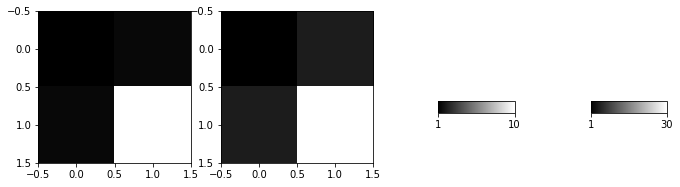

In [271]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[6, 3])

axins1 = inset_axes(ax1,
                   width="50%",  # width = 5% of parent_bbox width
                   height="8%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(2.1, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=5,
                   )

im1 = ax1.imshow([[1, 2], [2, 30]], cmap = 'gray')
fig.colorbar(im1, cax=axins1, orientation="horizontal", ticks=[1, 30])
axins1.xaxis.set_ticks_position("bottom")

axins = inset_axes(ax2,
                   width="50%",  # width = 5% of parent_bbox width
                   height="8%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.1, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=5,
                   )

# Controlling the placement of the inset axes is basically same as that
# of the legend.  you may want to play with the borderpad value and
# the bbox_to_anchor coordinate.

im = ax2.imshow([[1, 2], [2, 10]], cmap = 'gray')
fig.colorbar(im, cax=axins, orientation = 'horizontal', ticks=[1, 10])
plt.savefig(os.path.join(outdir, 'dummy_colorbars.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

N:\Singlem\singlem19-4\November\18_CLR_rois_NV\all\PQSpcm_2019-11-18_14-15-43.ptu


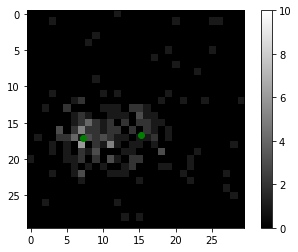

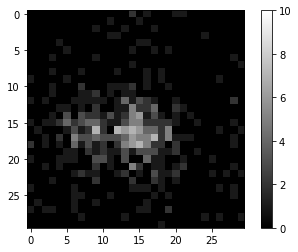

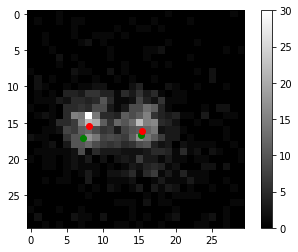

distance 1 is 0.62, distance 2 is 1.85


In [261]:
outdir = r'K:\vanderVoortN\papers\STED-FRET\figOrigami'
filterFRETCLR18Nov = df.selectSpotOccurence(FRETCLR18Nov, [2], [2])
cherryloc = filterFRETCLR18Nov[16] # other cherryloc 16
print(cherryloc['filepath'])
Gsnip = crop(cherryloc['G'].bitmap, cherryloc['ROI'])
Rsnip = crop(cherryloc['R'].bitmap, cherryloc['ROI'])
Ysnip = crop(cherryloc['Y'].bitmap, cherryloc['ROI'])


plt.imshow(Gsnip, cmap = 'gray', vmax = 10)
gpos = np.array([cherryloc['G'].spotLst[0].coord, cherryloc['G'].spotLst[1].coord])
plt.plot(gpos[:,1], gpos[:,0], 'go')
plt.colorbar()
plt.savefig(os.path.join(outdir,'Gloc.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

plt.imshow(Rsnip, cmap = 'gray', vmax = 10)
#dpos = np.array([cherryloc['R'].spotLst[0].coord, cherryloc['R'].spotLst[1].coord])
#print(dpos)
#plt.plot(dpos[:,1],dpos[:,0], 'go')
plt.colorbar()
plt.savefig(os.path.join(outdir,'Rloc.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

plt.imshow(Ysnip, cmap = 'gray', vmax = 30)
rpos = np.array([cherryloc['Y'].spotLst[0].coord, cherryloc['Y'].spotLst[1].coord])
plt.plot(gpos[:,1],gpos[:,0], 'go')
plt.plot(rpos[:,1],rpos[:,0], 'ro')
plt.colorbar()
plt.savefig(os.path.join(outdir,'Yloc.png'), dpi = 300, bbox_inches = 'tight')
plt.show()
print('distance 1 is %.2f, distance 2 is %.2f' % 
      (np.linalg.norm(cherryloc['FRETind'][0].dist),
       np.linalg.norm(cherryloc['FRETind'][1].dist)))

mean Green lifetime for C-LR is 3.3
mean Red lifetime for C-LR is 4.1
mean Yellow lifetime for C-LR is 4.0


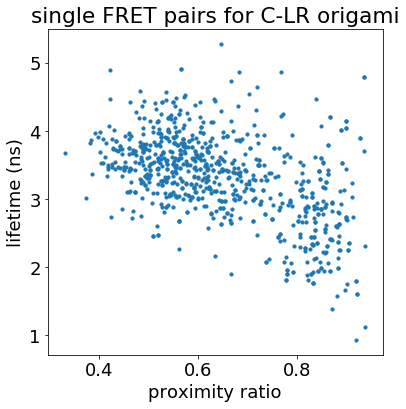

In [289]:
sample = 'C-LR'
plt.figure(figsize = (6,6))
plt.scatter(Eprox, tauG, s = 10)
mpl.rcParams.update({'font.size': 18})
plt.xlabel('proximity ratio')
plt.ylabel('lifetime (ns)')
plt.title('single FRET pairs for C-LR origami')
print('mean Green lifetime for %s is %.1f' %(sample, np.mean(tauG)))
print('mean Red lifetime for %s is %.1f' %(sample, np.mean(tauR)))
print('mean Yellow lifetime for %s is %.1f' %(sample, np.mean(tauY)))
plt.savefig(os.path.join(outdir, 'C-LR_super_super_res.png'), dpi = 300, bbox_inches = 'tight')

[-4.5209324   7.90969014]


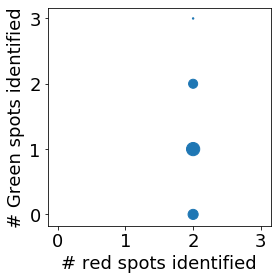

In [317]:
pxSize
A2CLR18Nov = df.selectSpotOccurence(CLR18Nov, [0,1,2,3], [2])
df.plotOccurence(A2FRETCLR18Nov)
A2dist = []
for loc in A2CLR18Nov:
    Rdist = loc['Y'].spotLst[0].coord - loc['Y'].spotLst[1].coord
    A2dist.append(Rdist)
A2dist = np.array(A2dist) * pxSize
A2dist = df.kickvector(A2dist, 120)
print(np.mean(A2dist, axis = 0))
A2dist = A2dist - np.mean(A2dist, axis = 0)

NameError: name 'minimize' is not defined

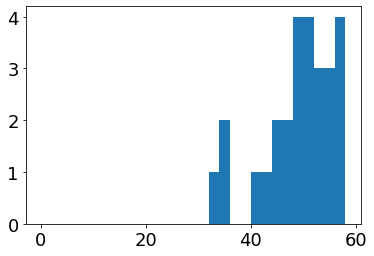

In [357]:
chiSigma = np.sqrt (Gprecision**2 + Yprecision**2 + posprecision**2)

#coords = plotSinglePair(filterCLLst, pxSize = pxSize)
counts, bin_edges, _ = plt.hist(np.linalg.norm(A2dist, axis = 1), bins = np.arange(0,60,2))

Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)

for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2
fixedbounds = ((0, None), (chiSigma, chiSigma), (None, None), (None, None))
params0 = [7, 7, 500,2]
fitres_fixed = minimize(logLikelihood1D, params0, args = (ncChidistr, bins, counts), 
                  method = 'SLSQP', bounds = fixedbounds)
xgrid = np.arange(0,max(bins),0.1)
fixedfit = ncChidistr(xgrid, *fitres_fixed.x)
plt.plot(xgrid, fixedfit, label = 'MLE sigma fixed')

freebounds = ((0, None), (None, None), (None, None), (None, None))
fitres_free = minimize(logLikelihood1D, params0, args = (ncChidistr, bins, counts), 
                  method = 'SLSQP', bounds = freebounds)
freefit = ncChidistr(xgrid, *fitres_free.x)
plt.plot(xgrid, freefit, label = 'MLE sigma free')
plt.legend()
plt.show()
print('fit res if sigma fixed' + str(fitres_fixed.x))
print('fit res if sigma free' + str(fitres_free.x))

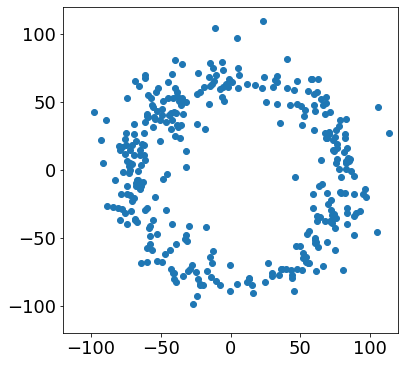

[7.47472747e+01 1.26361392e+01 6.68551265e+02 1.67002402e-01]


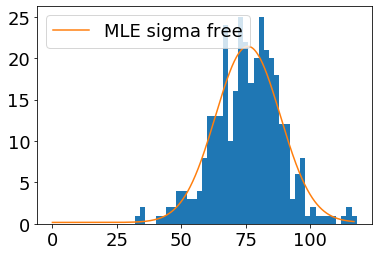

In [360]:

plt.figure(figsize = (6,6))
plt.scatter(A2dist[:,0], A2dist[:,1])
plt.xlim(-120,120)
plt.ylim(-120,120)
plt.show()


counts, bin_edges, _ = plt.hist(np.linalg.norm(A2dist, axis = 1), bins = np.arange(0,120,2))

Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)
for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2
params0 = [80, 15, 100,2]
bounds = ((0, None), (chiSigma, chiSigma+0.01), (None, None), (None, None))

fitres_free = df.minimize(df.logLikelihood1D, params0, args = (df.ncChidistr, bins, counts), 
                  method = 'SLSQP')
print(fitres_free.x)
xgrid = np.arange(0,max(bins),0.1)

freefit = df.ncChidistr(xgrid, *fitres_free.x)
plt.plot(xgrid, freefit, label = 'MLE sigma free')
plt.legend()
plt.show()

# Merged C-LR

In [2]:
wdir = r'P:\STED-FRET\Origamis\data\CLR'
CLR_merged = []
for file in os.listdir(wdir):
    if file.endswith('_an.spots'):
        ffile = os.path.join(wdir, file)
        print(ffile)
        CLR_merged += df.loadpickle(ffile)

P:\STED-FRET\Origamis\data\CLR\CLR16Jan_an.spots
P:\STED-FRET\Origamis\data\CLR\CLR18Nov_an.spots


In [321]:
outfile = r'K:\vanderVoortN\papers\STED-FRET\figOrigami\Origin\CLR_all_cut\CLR_stats.pg4'
All_stats = df.genStats(CLR_merged, outfile)

saving FRET indicators to disc for Margarita


In [ ]:
df.genStats

In [3]:
HF_Lst = df.filterFRETind(CLR_merged, 'proxRatio', 0.75, 1)
HF_stats = df.genStats(HF_Lst)
NF_Lst = df.filterFRETind(CLR_merged, 'proxRatio', 0, 0.75)
NF_stats = df.genStats(NF_Lst)

### HF fraction

In [285]:
HF_Lst = df.filterFRETind(CLR_merged, 'proxRatio', 0.75, 1)
HF_stats = df.genStats(HF_Lst)
HF_stats = df.filterStats(HF_stats, 'stoichiometry', 0.2, 0.8)
#HF_stats = df.filterStats(HF_stats, 'sigmaG', 2.4, 4)
#HF_stats = df.filterStats(HF_stats, 'sigmaY', 2, 3.2)
#HF_stats = df.filterStats(HF_stats, 'AY', 0, 30)
#HF_stats = df.filterStats(HF_stats, 'AG', 0, 6)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  2., 11., 29., 25., 33., 39., 43.,
        21., 21., 17., 28., 16., 16., 14.,  1.,  7.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
        0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
        0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
        0.99]),
 <a list of 33 Patch objects>)

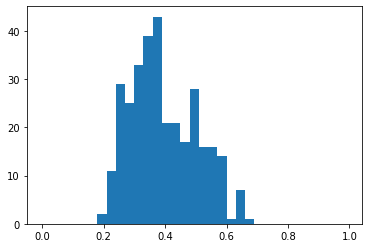

In [286]:
plt.hist(HF_stats['stoichiometry'], bins = np.arange(0,1, 0.03))

5.0 in x and 0.0 in y subtracted
fit for 3 peaks failed
AIC is 533.2 for 0 peaks
AIC is 134.3 for 1 peaks
AIC is 122.6 for 2 peaks
BIC is 536.9 for 0 peaks
BIC is 149.4 for 1 peaks
BIC is 149.0 for 2 peaks


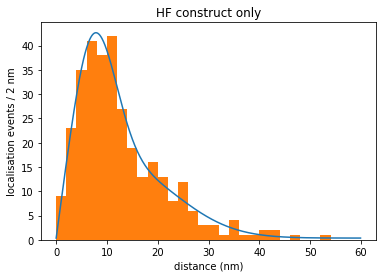

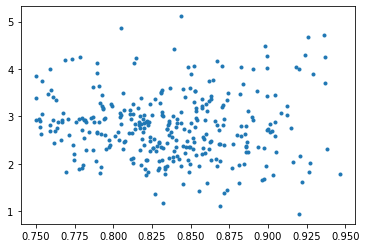

In [287]:
maxval = 100
HF_dist = np.array((HF_stats['distx'], HF_stats['disty'])).transpose()
HF_dist = df.filterVec(HF_dist, maxval = maxval, verbose = True, center = [5,0])
HF_distnorm = np.linalg.norm(HF_dist, axis = 1)


#outfile = r'K:\vanderVoortN\papers\STED-FRET\figOrigami\Origin\CLR_distdict_HF_trimmed.txt'
#distDict = {}
#distDict ['distx'] = HF_dist[:,0]
#distDict ['disty'] = HF_dist[:,1]
#distDict['distnorm'] = HF_distnorm
#df.saveDict(distDict, outfile)

modelout = r'K:\vanderVoortN\papers\STED-FRET\figOrigami\Origin\CLR_HF_chiFit_trimmed.txt'
fitres = df.whichChiIsBest(HF_distnorm, verbose = True, title = 'HF construct only', modelout = modelout)
plt.plot(HF_stats['proxRatio'], HF_stats['tauG'], '.')
fitres

5.0 in x and 0.0 in y subtracted
AIC is 121.6 for 0 peaks
AIC is 121.6 for 1 peaks
AIC is 121.6 for 2 peaks
AIC is 121.6 for 3 peaks
BIC is 144.5 for 0 peaks
BIC is 144.5 for 1 peaks
BIC is 144.5 for 2 peaks
BIC is 144.5 for 3 peaks


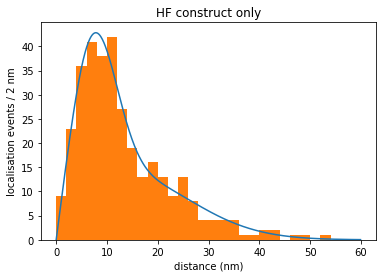

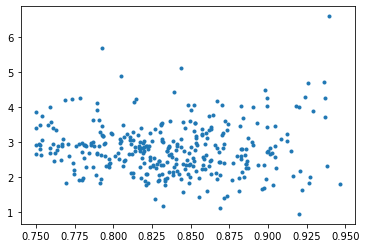

In [319]:
HF_Lst = df.filterFRETind(CLR_merged, 'proxRatio', 0.75, 1)
HF_stats = df.genStats(HF_Lst)

maxval = 100
HF_dist = np.array((HF_stats['distx'], HF_stats['disty'])).transpose()
HF_dist = df.filterVec(HF_dist, maxval = maxval, center = [5,0])
HF_distnorm = np.linalg.norm(HF_dist, axis = 1)
outfile = r'K:\vanderVoortN\papers\STED-FRET\figOrigami\Origin\CLR_HF_cut\CLR_distdict_HF.txt'
distDict = {}
distDict ['distx'] = HF_dist[:,0]
distDict ['disty'] = HF_dist[:,1]
distDict['distnorm'] = HF_distnorm
df.saveDict(distDict, outfile)

modelout = r'K:\vanderVoortN\papers\STED-FRET\figOrigami\Origin\CLR_HF_cut\CLR_HF_chiFit.txt'
plotout = r'K:\vanderVoortN\papers\STED-FRET\figOrigami\Origin\CLR_HF_cut\CLR_HF_subpopulation.png'
p = df.genPeakEst(2, counts, bins)
p['bg'].set(vary = False, value = 0)
p['mu0'].set(vary = True, value = 6)
p['sig0'].set(vary = True, value = 4.6)
p['mu1'].set(vary = True, value = 10)
p['sig1'].set(vary = True, value = 4.6)
#p['sig0'].set(vary = True, value = 4.6)
fitres = df.whichChiIsBest(HF_distnorm, p = p, verbose = True, title = 'HF construct only', 
                           modelout = modelout, plotout = plotout, maxbin = 60)
plt.plot(HF_stats['proxRatio'], HF_stats['tauG'], '.')
fitres

AIC is 176.5 for 0 peaks
AIC is 176.5 for 1 peaks
AIC is 176.5 for 2 peaks
AIC is 176.5 for 3 peaks
BIC is 191.7 for 0 peaks
BIC is 191.7 for 1 peaks
BIC is 191.7 for 2 peaks
BIC is 191.7 for 3 peaks


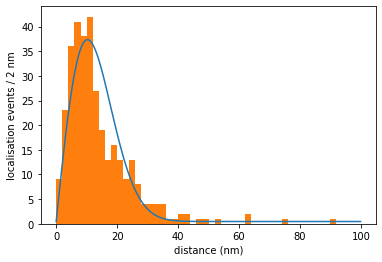

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
A0       625.4        0 4.900e+04     None     True     None     None
bg      0.4656        0 4.900e+04     None     True     None     None
mu0   0.003484        0     98.5     None     True     None     None
sig0     10.28        0      inf     None     True     None     None


In [300]:
dist = HF_distnorm
maxbin = 100
binwidth = 1
counts, bin_edges, _ = plt.hist(dist, bins = np.arange(0, maxbin, binwidth))
plt.clf()
Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)
for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

p = df.genPeakEst(2, counts, bins)
#p['bg'].set(vary = False, value = 0)
#p['sig0'].set(vary = True, value = 4.6)
fitres = df.whichChiIsBest(dist, p = p, verbose = True, maxbin = maxbin)
p = fitres.params
fitres.params.pretty_print()

In [233]:
print('mean NG is %.0f' %
      np.mean(np.array(HF_stats['AG']) * np.array(HF_stats['sigmaG'])**2 *2 * np.pi))
print('mean sigmaG is %.2f' % (np.mean(HF_stats['sigmaG'])*10))
print('mean bgG is %.2f' % np.mean(HF_stats['bgG']))
print('mean NY is %.0f' %
      np.mean(np.array(HF_stats['AY']) * np.array(HF_stats['sigmaY'])**2 *2 * np.pi))
print('mean sigmaY is %.2f' % (np.mean(HF_stats['sigmaY'])*10))
print('mean bgY is %.2f' % np.mean(HF_stats['bgY']))
df.estChiSigma(29, 25, 147, 605, 0.11, 0.58, 10, 2)

mean NG is 147
mean sigmaG is 29.40
mean bgG is 0.12
mean NY is 605
mean sigmaY is 25.08
mean bgY is 0.58
integral in variance has value -0.271200
integral in variance has value -0.264806


3.653995792338261

### NF Fraction

In [21]:
NF_Lst = df.filterFRETind(CLR_merged, 'proxRatio', 0, 0.75)
NF_stats = df.genStats(NF_Lst)

(array([13.,  2.,  1.,  1.,  4., 13., 25., 23., 27., 31., 49., 47., 30.,
        19., 15.,  7.,  7.,  5.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <a list of 19 Patch objects>)

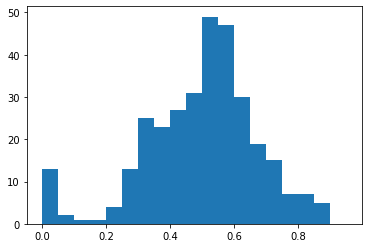

In [180]:
plt.hist(NF_stats['stoichiometry'], bins = np.arange(0,1,.05))

In [281]:
NF_Lst = df.filterFRETind(CLR_merged, 'proxRatio', 0, 0.6)
NF_stats = df.genStats(NF_Lst)
NF_stats = df.filterStats(NF_stats, 'stoichiometry', 0.2, 0.8)
#NF_stats = df.filterStats(NF_stats, 'sigmaG', 2.2, 4.5)
#NF_stats = df.filterStats(NF_stats, 'sigmaY', 2, 4)

#NF_stats = df.filterStats(NF_stats, 'proxRatio', 0, 0.6)

(array([  0.,   0.,   0.,   0.,  24.,  49.,  80.,  79.,  76.,  77., 103.,
         77.,  53.,  43.,  27.,  15.,   2.,   0.,   0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <a list of 19 Patch objects>)

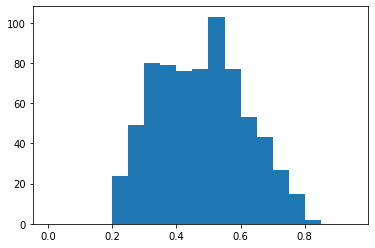

In [282]:
plt.hist(NF_stats['stoichiometry'], bins = np.arange(0,1,.05))

5.0 in x and 0.0 in y subtracted
fit for 2 peaks failed
AIC is 1027.9 for 0 peaks
AIC is 328.8 for 1 peaks
BIC is 1032.5 for 0 peaks
BIC is 347.0 for 1 peaks


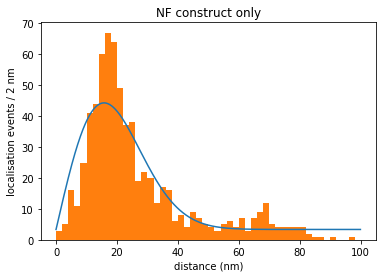

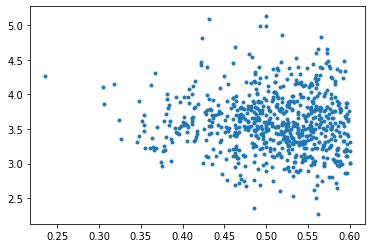

In [291]:
maxval = 100
NF_dist = np.array((NF_stats['distx'], NF_stats['disty'])).transpose()
NF_dist = df.filterVec(NF_dist, maxval = maxval, center = [5,0])
NF_distnorm = np.linalg.norm(NF_dist, axis = 1)

fitres = df.whichChiIsBest(NF_distnorm, verbose = True, title = 'NF construct only', maxbin = 100)
plt.plot(NF_stats['proxRatio'], NF_stats['tauG'], '.')
fitres

In [294]:
reload(df)

<module 'developmental_functions' from 'K:\\vanderVoortN\\FRC\\Code\\developmental_functions.py'>

5.0 in x and 0.0 in y subtracted
AIC is 234.2 for 0 peaks
AIC is 234.2 for 1 peaks
AIC is 234.2 for 2 peaks
AIC is 234.2 for 3 peaks
BIC is 275.1 for 0 peaks
BIC is 275.1 for 1 peaks
BIC is 275.1 for 2 peaks
BIC is 275.1 for 3 peaks


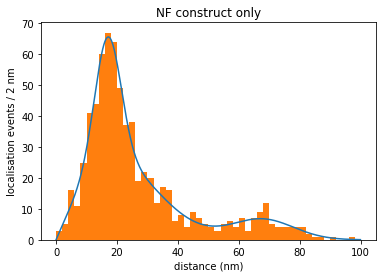

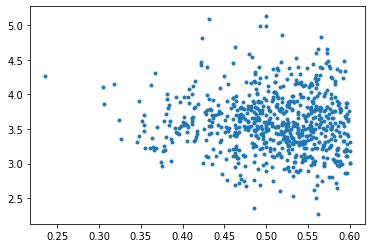

In [299]:
maxval = 100
NF_dist = np.array((NF_stats['distx'], NF_stats['disty'])).transpose()
NF_dist = df.filterVec(NF_dist, maxval = maxval, center = [5,0])
NF_distnorm = np.linalg.norm(NF_dist, axis = 1)
outfile = r'K:\vanderVoortN\papers\STED-FRET\figOrigami\Origin\CLR_NF_cut\CLR_distdict_HF.txt'
distDict = {}
distDict ['distx'] = NF_dist[:,0]
distDict ['disty'] = NF_dist[:,1]
distDict['distnorm'] = NF_distnorm
df.saveDict(distDict, outfile)

modelout = r'K:\vanderVoortN\papers\STED-FRET\figOrigami\Origin\CLR_NF_cut\CLR_NF_chiFit.txt'
plotout = r'K:\vanderVoortN\papers\STED-FRET\figOrigami\Origin\CLR_NF_cut\CLR_NF_plt.png'

dist = NF_distnorm
maxbin = 100
binwidth = 1
counts, bin_edges, _ = plt.hist(dist, bins = np.arange(0, maxbin, binwidth))
plt.clf()
Nbins = bin_edges.shape[0] - 1
bins = np.zeros(Nbins)
for i in range(Nbins):
    bins[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

p = df.genPeakEst(3, counts, bins)
p['bg'].set(vary = False, value = 0)
p['mu2'].set(vary = True, value = 30)
#p['mu0'].set(vary = False, value = 7.1)
#p['sig0'].set(vary = False, value = 4.6)
fitres = df.whichChiIsBest(NF_distnorm, p = p, verbose = True, title = 'NF construct only', 
                           modelout = modelout, plotout = plotout, maxbin = maxbin)
plt.plot(NF_stats['proxRatio'], NF_stats['tauG'], '.')
fitres

In [52]:
reload(df)

<module 'developmental_functions' from 'K:\\vanderVoortN\\FRC\\Code\\developmental_functions.py'>

In [156]:
HF_stats2 = df.genStats(CLR_merged)
HF_stats2 = df.filterStats(HF_stats2, 'proxRatio', 0, .75)
HF_stats2 = df.filterStats(HF_stats2, 'AG', 0, 5)

5.0 in x and 0.0 in y subtracted
fit for 3 peaks failed
AIC is 486.0 for 0 peaks
AIC is 138.6 for 1 peaks
AIC is 132.6 for 2 peaks
BIC is 489.8 for 0 peaks
BIC is 153.8 for 1 peaks
BIC is 159.4 for 2 peaks


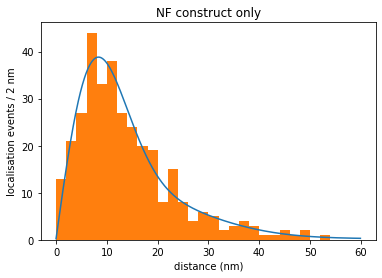

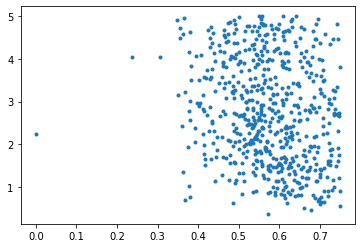

In [157]:
maxval = 100
HF_dist2 = np.array((HF_stats2['distx'], HF_stats2['disty'])).transpose()
HF_dist2 = df.filterVec(HF_dist, maxval = maxval, center = [5,0])
HF_distnorm2 = np.linalg.norm(HF_dist2, axis = 1)

fitres = df.whichChiIsBest(HF_distnorm2, verbose = True, title = 'NF construct only')
plt.plot(HF_stats2['proxRatio'], HF_stats2['AG'], '.')
fitres

In [368]:
print('mean NG is %.0f' %
      np.mean(np.array(NF_stats['AG']) * np.array(NF_stats['sigmaG'])**2 *2 * np.pi))
print('mean sigmaG is %.2f' % (np.mean(NF_stats['sigmaG'])*10))
print('mean bgG is %.2f' % np.mean(NF_stats['bgG']))
print('mean NY is %.0f' %
      np.mean(np.array(NF_stats['AY']) * np.array(NF_stats['sigmaY'])**2 *2 * np.pi))
print('mean sigmaY is %.2f' % (np.mean(NF_stats['sigmaY'])*10))
print('mean bgY is %.2f' % np.mean(NF_stats['bgY']))
df.estChiSigma(29, 25, 147, 605, 0.11, 0.58, 10, 2)

mean NG is 336
mean sigmaG is 33.21
mean bgG is 0.12
mean NY is 783
mean sigmaY is 26.95
mean bgY is 0.58
integral in variance has value -0.271200
integral in variance has value -0.264806


3.653995792338261